## <center> Практическое задание к лекции №7

**1.** К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от номера соседа.  
**2.** К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей в зависимости от расстояния до соседа. Сравнить метрики качества и сложность разделяющей гиперплоскости. Сделать выводы.  
**3.** Настроить оптимальное значение числа соседей для моделей из п.1 и п.2, сделать выводы.  
**4(опция).** Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

**1 - 3**

---

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator

class KNNClassifier(BaseEstimator, TransformerMixin):

    def __init__(self, k: int = 3, weights: str='uniform'):
        
        
        self.weights=weights
            
        self.k = k
        if weights not in ['uniform','distance','number']:
            raise ValueError(
                'значения параметра weights могут быть "uniform", "distance" или "number"'
            )


    def fit(self, X, y):
        self.X = X
        self.y = y

        return self

    def predict(self, X):
        answers = []
        for x in X:
            test_distances = []                
            for i in range(len(self.X)):                
                # расчет расстояния от классифицируемого объекта до
                # объекта обучающей выборки
                distance = self.e_metrics(x,self.X[i])                
                # Записываем в список значение расстояния и ответа на объекте обучающей выборки
                test_distances.append((distance, self.y[i]))
                if self.weights=='uniform':
                    classes = self.without_weigth(test_distances)
                elif  self.weights=='distance':
                    classes=self.dist_weights(test_distances) 
                else: 
                    classes=self.num_weights(test_distances)      
                
            # Записываем в список ответов наиболее часто встречающийся класс
            answers.append(sorted(classes, key=classes.get)[-1])
        return answers
    
    
    def e_metrics(self,x1, x2):    
        distance = 0
        for i in range(len(x1)):
            distance += np.square(x1[i] - x2[i])      
        return np.sqrt(distance)
    
    
    def without_weigth(self, test_distances):
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(self.y)}
         # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        #print(sorted(test_distances)[0:self.k])
        for d in sorted(test_distances)[0:self.k]:
            classes[d[1]] += 1
        return classes
    
    # реализуем добавление весов в зависимости от растояния до соседа
    def dist_weights(self, test_distances):
        classes = {class_item: 0 for class_item in set(self.y)}
         # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:self.k]:
            classes[d[1]] += 0.9**d[0]
        return classes
    
    # реализуем добавление весов в зависимости от номера соседа    
    def num_weights(self, test_distances):
        classes = {class_item: 0 for class_item in set(self.y)}
         # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for idx, d in enumerate(sorted(test_distances)[0:self.k]):
            classes[d[1]] += (self.k+1-(idx+1))/self.k 
        return classes
        
    
    @staticmethod
    def accuracy(pred, y):
        return (sum(pred == y) / len(y))

Создадим датасет

In [3]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

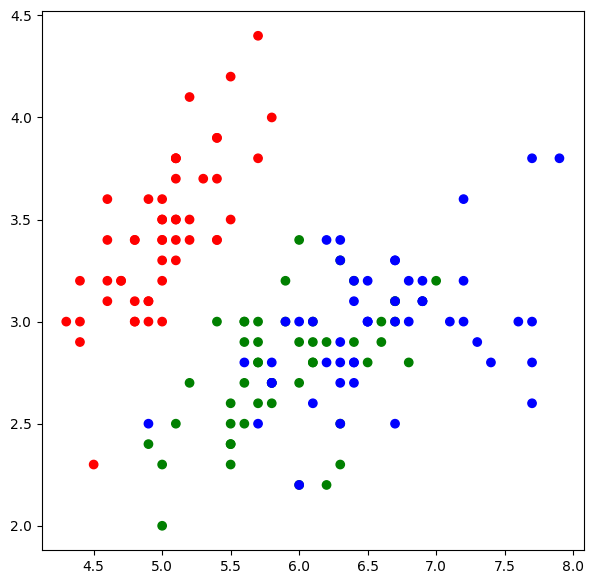

In [5]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Сравним точность алгоритмов

In [6]:
mod=KNNClassifier(k=10)
mod.fit(X_train, y_train)
y_pred=mod.predict(X_test)
print(f'Точность алгоритма при k = {mod.k}, и методе присвоения весов = {mod.weights}: {mod.accuracy(y_pred, y_test): .3f}')

Точность алгоритма при k = 10, и методе присвоения весов = uniform:  0.833


In [7]:
mod=KNNClassifier(k=10, weights='distance')
mod.fit(X_train, y_train)
y_pred=mod.predict(X_test)
print(f'Точность алгоритма при k = {mod.k}, и методе присвоения весов = {mod.weights}: {mod.accuracy(y_pred, y_test): .3f}')

Точность алгоритма при k = 10, и методе присвоения весов = distance:  0.867


In [8]:
mod=KNNClassifier(k=10, weights='number')
mod.fit(X_train, y_train)
y_pred=mod.predict(X_test)
print(f'Точность алгоритма при k = {mod.k}, и методе присвоения весов = {mod.weights}: {mod.accuracy(y_pred, y_test): .3f}')

Точность алгоритма при k = 10, и методе присвоения весов = number:  0.867


In [9]:
def get_graph(X_train, y_train, k, weights: str):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mod=KNNClassifier(k=k, weights=weights)
    mod.fit(X_train,y_train)
    # Получим предсказания для всех точек
    Z = mod.predict(np.c_[xx.ravel(), yy.ravel()])

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}\n метод присвоения веса = {weights}")
    plt.show()

Сравним классификацию при разном определении весов соседей

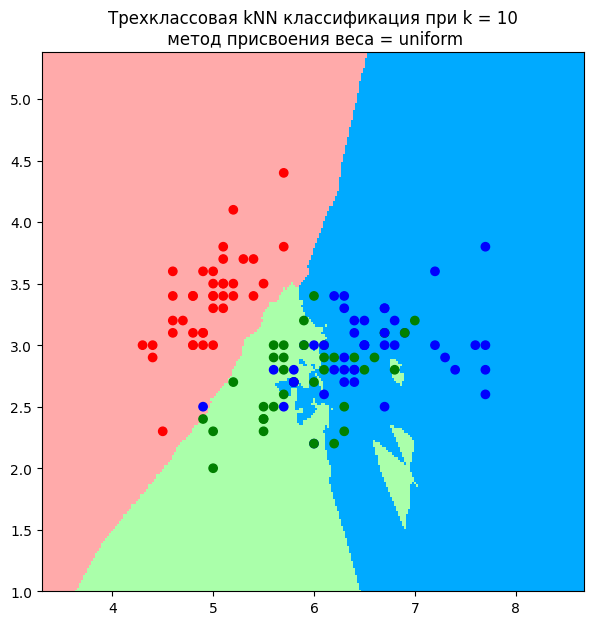

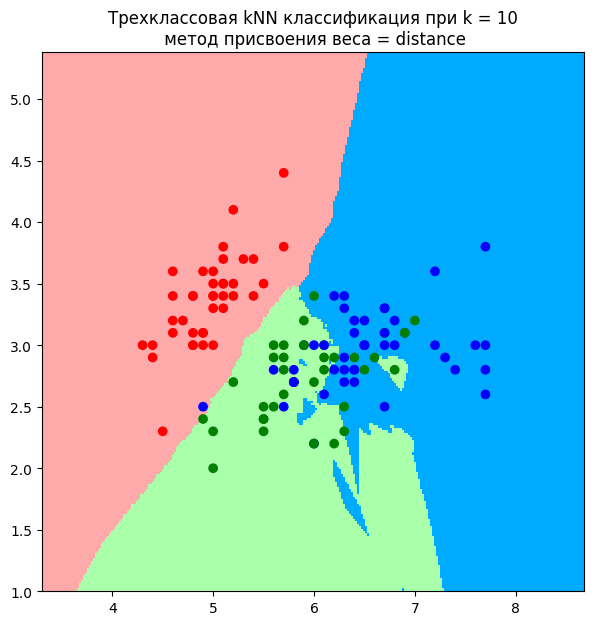

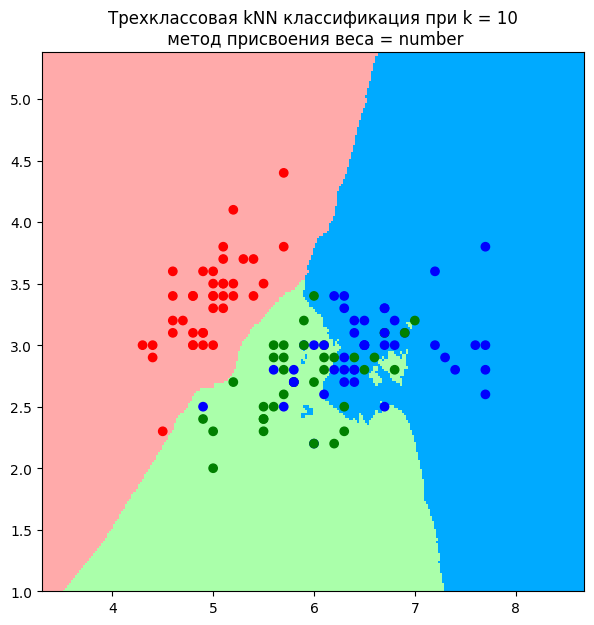

In [10]:
for weights in ['uniform','distance','number']:
    get_graph(X_train, y_train, 10, weights)

Подберем оптимальное количество соседей для каждого метода:

In [11]:
meth_list=['uniform','distance','number']
acc_dict={meth:[] for meth in meth_list}
n_neighbors=list(range(1,21))
for meth in meth_list:
    for neighbor in n_neighbors:
        mod=KNNClassifier(k=neighbor, weights=meth)
        y_pred=mod.fit(X_train,y_train).predict(X_test)
        acc_dict[meth].append(mod.accuracy(y_pred, y_test))

In [12]:
acc_dict

{'uniform': [0.6666666666666666,
  0.6666666666666666,
  0.7333333333333333,
  0.8333333333333334,
  0.8666666666666667,
  0.8333333333333334,
  0.8,
  0.8,
  0.8666666666666667,
  0.8333333333333334,
  0.8333333333333334,
  0.8,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8,
  0.8333333333333334,
  0.8333333333333334],
 'distance': [0.6666666666666666,
  0.7333333333333333,
  0.7333333333333333,
  0.8,
  0.8666666666666667,
  0.8666666666666667,
  0.8,
  0.8666666666666667,
  0.8666666666666667,
  0.8666666666666667,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334],
 'number': [0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.7333333333333333,
  0.7333333333333333,
  0.7666666666666667,
  0.8333333333333334,
  0.8333333333333334,

<function matplotlib.pyplot.show(close=None, block=None)>

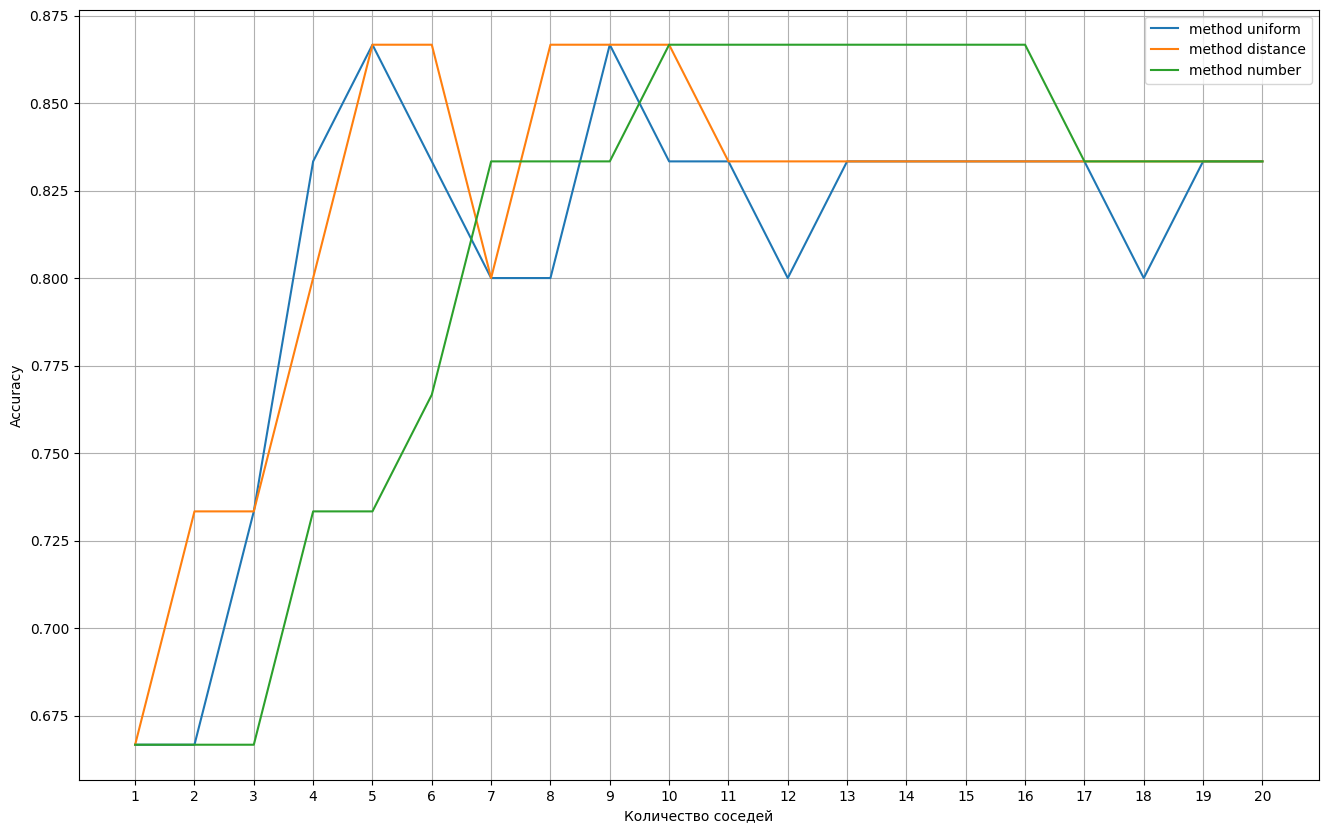

In [13]:
plt.figure(figsize=(16,10))
for key,val in acc_dict.items():
    plt.plot(n_neighbors, acc_dict[key],  label=f'method {key}')
plt.grid()
plt.xticks(n_neighbors)
plt.xlabel('Количество соседей')
plt.ylabel('Accuracy')
plt.legend()
plt.show

Из представленных графиков видно, что использование метода весов в зависимости от дистанции до ближайших к-соседей либо от номера блихайшего соседа, делает разделяющую гиперплоскость менее сложной, при этом точность этих моделей сопоставима.  


Оптимальное количество соседей для модели без учёта весов, и модели с учётом весов в зависимости от расстояния - 5, а для модели с учетом весов в зависимости от номера - 10.